<a href="https://colab.research.google.com/github/porkens/myTestRepo/blob/main/Laborki_optymalizacja_liter_optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''Trains a simple deep NN on the MNIST dataset.

Gets to 99.6% test accuracy after 40 epochs
(there is *a lot* of margin for parameter tuning).
2 seconds per epoch on a K520 GPU.
'''

from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np





import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.optimizers import RMSprop, Adam, Adadelta
from keras.preprocessing.image import ImageDataGenerator

from keras.utils.vis_utils import plot_model
from IPython.display import Image 

from keras.callbacks import EarlyStopping

batch_size = 128
num_classes = 10
epochs = 200

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train0), (x_test, y_test0) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

! pip install optuna


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train0, num_classes)
y_test = keras.utils.to_categorical(y_test0, num_classes)

N_TRAIN_EXAMPLES=500 #3000
N_TEST_EXAMPLES=10000

x_train=x_train[:N_TRAIN_EXAMPLES]
x_test=x_test[:N_TEST_EXAMPLES]
y_train=y_train[:N_TRAIN_EXAMPLES]
y_test=y_test[:N_TEST_EXAMPLES]

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

import optuna

500 train samples
10000 test samples


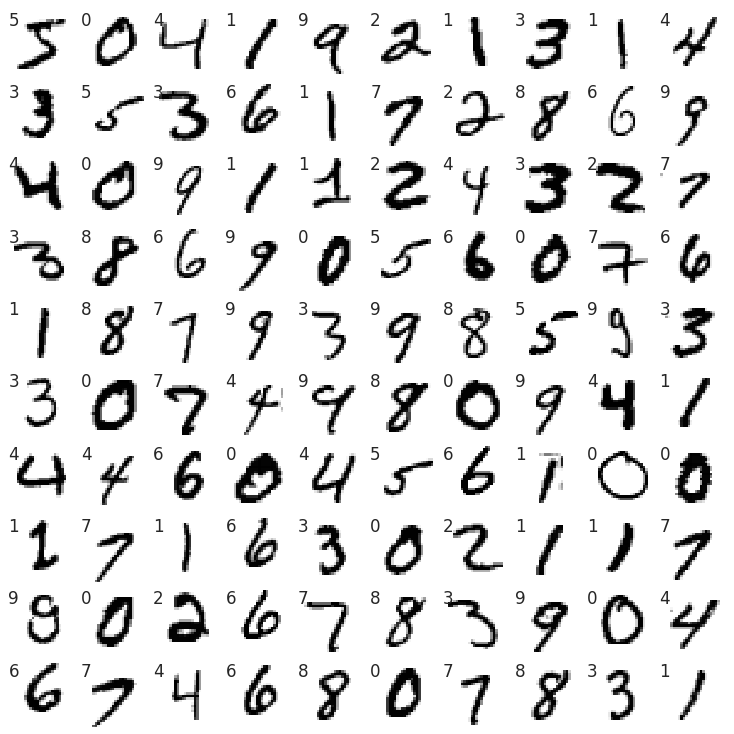

In [ ]:
#visualize the digits

fig = plt.figure(figsize=(10, 10))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(x_train[i].reshape(img_rows, img_cols), cmap=plt.cm.binary, interpolation='nearest')
    # label the image with the target value
    ax.text(0, 7, str(y_train0[i]))

In [ ]:
# set up image augmentation
datagen = ImageDataGenerator( 
    rotation_range=30,
    horizontal_flip=False,
    vertical_flip=False,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15
    )
datagen.fit(x_train)

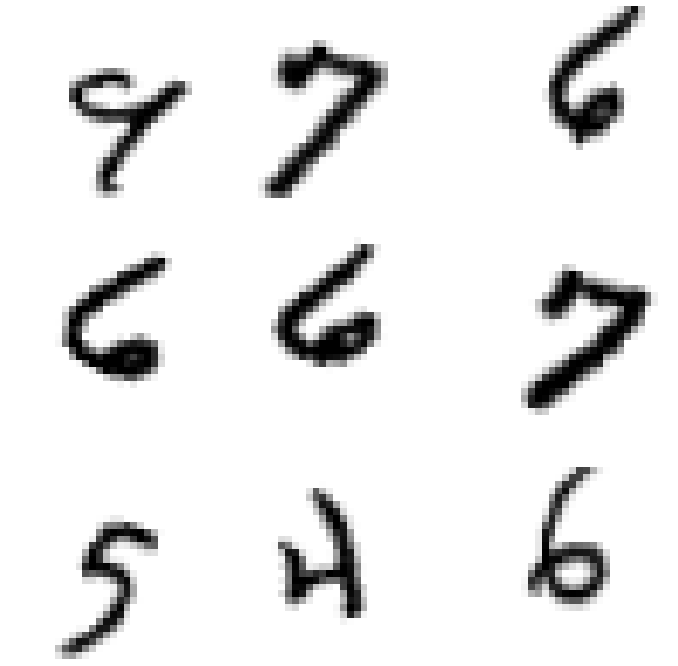

In [ ]:
# see example augmentation images

fig = plt.figure(figsize=(12, 12))
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    for i in range(0, 9):
         plt.subplot(330 + 1 + i)
         plt.imshow(X_batch[i].reshape(img_rows,img_cols),cmap=plt.cm.binary, interpolation='nearest')
         plt.axis('off')
    plt.show()
    break

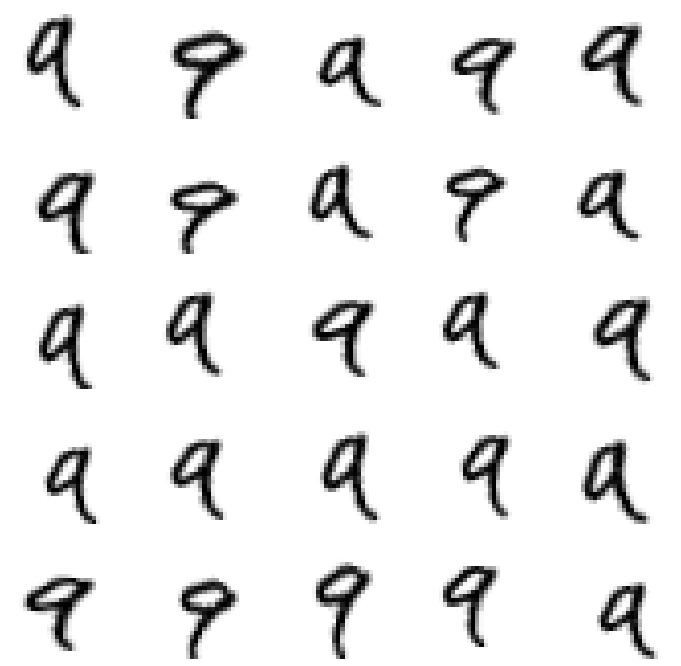

In [ ]:
# see example augmentation images
fig = plt.figure(figsize=(12, 12))

for i in range(0, 25):
    for X_batch, y_batch in datagen.flow(x_train[4:7], y_train[4:7], batch_size=1, shuffle=False):
         plt.subplot(5,5,i+1)
         plt.imshow(X_batch[0].reshape(img_rows,img_cols),cmap=plt.cm.binary, interpolation='nearest')
         plt.axis('off')
         break

plt.show()

In [ ]:
def create_model():
  # Our old fully connected (dense) network
  #model = Sequential()
  #model.add(Dense(512, activation='relu', input_shape=(784,)))
  #model.add(Dropout(0.2))
  #model.add(Dense(512, activation='relu'))
  #model.add(Dropout(0.2))
  #model.add(Dense(512, activation='relu'))
  #model.add(Dropout(0.2))
  #model.add(Dense(num_classes, activation='softmax'))

  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))


  return model 
  #model.summary()



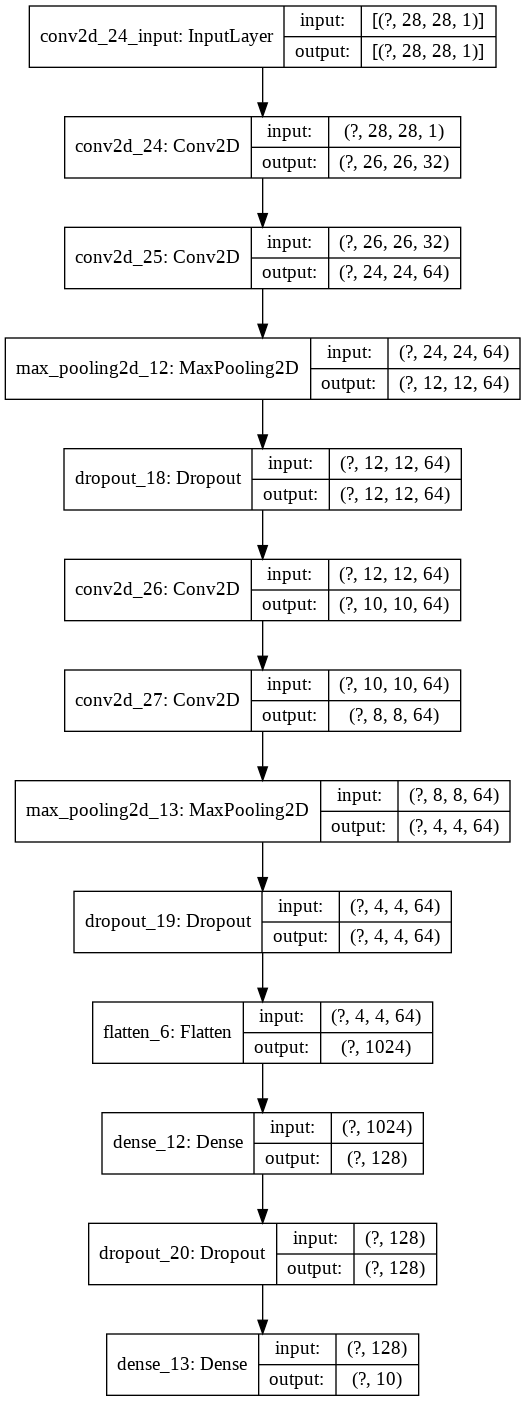

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
Image('model_plot.png')

In [ ]:
def objective(trial):

  #clear_session()

  rotation_range = trial.suggest_uniform('rotation_range', .00,30)
  zoom_range = trial.suggest_uniform('zoom_range', .00,0.30)
  shift_range = trial.suggest_uniform('shift_range', .00,0.20)

  datagen = ImageDataGenerator(
      rotation_range=rotation_range,
      zoom_range=zoom_range,
      width_shift_range = shift_range,
      height_shift_range = shift_range
  )
  model = create_model()

  model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

  es = EarlyStopping(monitor = 'val_accuracy', patience =12, verbose=1)

  history = model.fit(datagen.flow(x_train, y_train,batch_size=batch_size),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_data=(x_test, y_test),
                    callbacks = [es])
  score = model.evaluate(x_test, y_test, verbose=0)
  return score[1]


In [ ]:
study = optuna.create_study(direction="maximize",sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=50, timeout=1000)

[I 2020-12-15 11:50:47,757] A new study created in memory with name: no-name-05f74cde-8822-41a6-83cb-320dccdc95fe


Epoch 1/200
4/4 [==============================] - 1s 139ms/step - loss: 2.3057 - accuracy: 0.1060 - val_loss: 2.2809 - val_accuracy: 0.2293
Epoch 2/200
4/4 [==============================] - 0s 101ms/step - loss: 2.2780 - accuracy: 0.1620 - val_loss: 2.2562 - val_accuracy: 0.2943
Epoch 3/200
4/4 [==============================] - 0s 104ms/step - loss: 2.2615 - accuracy: 0.1880 - val_loss: 2.1835 - val_accuracy: 0.3338
Epoch 4/200
4/4 [==============================] - 0s 104ms/step - loss: 2.2366 - accuracy: 0.2120 - val_loss: 2.0450 - val_accuracy: 0.3748
Epoch 5/200
4/4 [==============================] - 0s 100ms/step - loss: 2.1784 - accuracy: 0.2240 - val_loss: 1.8521 - val_accuracy: 0.5013
Epoch 6/200
4/4 [==============================] - 0s 99ms/step - loss: 2.0782 - accuracy: 0.2720 - val_loss: 1.5944 - val_accuracy: 0.6395
Epoch 7/200
4/4 [==============================] - 0s 97ms/step - loss: 1.9529 - accuracy: 0.2940 - val_loss: 1.4233 - val_accuracy: 0.5736
Epoch 8/200
4/4

[I 2020-12-15 11:51:31,423] Trial 0 finished with value: 0.954200029373169 and parameters: {'rotation_range': 5.6154201347291846, 'zoom_range': 0.017038731433021724, 'shift_range': 0.16856545941202603}. Best is trial 0 with value: 0.954200029373169.


Epoch 1/200
4/4 [==============================] - 0s 125ms/step - loss: 2.2999 - accuracy: 0.1120 - val_loss: 2.2751 - val_accuracy: 0.2968
Epoch 2/200
4/4 [==============================] - 0s 97ms/step - loss: 2.2572 - accuracy: 0.1840 - val_loss: 2.1896 - val_accuracy: 0.5243
Epoch 3/200
4/4 [==============================] - 0s 93ms/step - loss: 2.1726 - accuracy: 0.2740 - val_loss: 1.9037 - val_accuracy: 0.6101
Epoch 4/200
4/4 [==============================] - 0s 95ms/step - loss: 1.9355 - accuracy: 0.3680 - val_loss: 1.3747 - val_accuracy: 0.7006
Epoch 5/200
4/4 [==============================] - 0s 94ms/step - loss: 1.6661 - accuracy: 0.4580 - val_loss: 0.9746 - val_accuracy: 0.7485
Epoch 6/200
4/4 [==============================] - 0s 96ms/step - loss: 1.4280 - accuracy: 0.5300 - val_loss: 0.7949 - val_accuracy: 0.7729
Epoch 7/200
4/4 [==============================] - 0s 94ms/step - loss: 1.2151 - accuracy: 0.6100 - val_loss: 0.6724 - val_accuracy: 0.7875
Epoch 8/200
4/4 [==

[I 2020-12-15 11:52:01,886] Trial 1 finished with value: 0.9697999954223633 and parameters: {'rotation_range': 20.7107333907639, 'zoom_range': 0.17153997141156507, 'shift_range': 0.06504866020173104}. Best is trial 1 with value: 0.9697999954223633.


Epoch 1/200
4/4 [==============================] - 1s 126ms/step - loss: 2.3058 - accuracy: 0.1060 - val_loss: 2.2910 - val_accuracy: 0.1299
Epoch 2/200
4/4 [==============================] - 0s 92ms/step - loss: 2.2935 - accuracy: 0.1160 - val_loss: 2.2690 - val_accuracy: 0.1435
Epoch 3/200
4/4 [==============================] - 0s 95ms/step - loss: 2.2797 - accuracy: 0.1280 - val_loss: 2.2337 - val_accuracy: 0.1198
Epoch 4/200
4/4 [==============================] - 0s 94ms/step - loss: 2.2632 - accuracy: 0.1460 - val_loss: 2.1726 - val_accuracy: 0.2784
Epoch 5/200
4/4 [==============================] - 0s 94ms/step - loss: 2.2452 - accuracy: 0.1660 - val_loss: 2.1028 - val_accuracy: 0.4770
Epoch 6/200
4/4 [==============================] - 0s 96ms/step - loss: 2.2158 - accuracy: 0.2020 - val_loss: 1.9740 - val_accuracy: 0.4898
Epoch 7/200
4/4 [==============================] - 0s 95ms/step - loss: 2.1725 - accuracy: 0.2160 - val_loss: 1.8332 - val_accuracy: 0.4311
Epoch 8/200
4/4 [==

[I 2020-12-15 11:52:59,572] Trial 2 finished with value: 0.9635999798774719 and parameters: {'rotation_range': 16.9606497296471, 'zoom_range': 0.20031904891172705, 'shift_range': 0.1932114468313373}. Best is trial 1 with value: 0.9697999954223633.


Epoch 1/200
4/4 [==============================] - 0s 123ms/step - loss: 2.2953 - accuracy: 0.1080 - val_loss: 2.2710 - val_accuracy: 0.2870
Epoch 2/200
4/4 [==============================] - 0s 91ms/step - loss: 2.2554 - accuracy: 0.1780 - val_loss: 2.1774 - val_accuracy: 0.4426
Epoch 3/200
4/4 [==============================] - 0s 93ms/step - loss: 2.1602 - accuracy: 0.2240 - val_loss: 1.9305 - val_accuracy: 0.5053
Epoch 4/200
4/4 [==============================] - 0s 92ms/step - loss: 2.0095 - accuracy: 0.3200 - val_loss: 1.5593 - val_accuracy: 0.5854
Epoch 5/200
4/4 [==============================] - 0s 92ms/step - loss: 1.7861 - accuracy: 0.4220 - val_loss: 1.2490 - val_accuracy: 0.6565
Epoch 6/200
4/4 [==============================] - 0s 93ms/step - loss: 1.5761 - accuracy: 0.4580 - val_loss: 1.0449 - val_accuracy: 0.6749
Epoch 7/200
4/4 [==============================] - 0s 92ms/step - loss: 1.4147 - accuracy: 0.5300 - val_loss: 0.8385 - val_accuracy: 0.7497
Epoch 8/200
4/4 [==

[I 2020-12-15 11:53:29,404] Trial 3 finished with value: 0.9599000215530396 and parameters: {'rotation_range': 5.248155338987928, 'zoom_range': 0.11033704683846142, 'shift_range': 0.08947384624847712}. Best is trial 1 with value: 0.9697999954223633.


Epoch 1/200
4/4 [==============================] - 0s 122ms/step - loss: 2.2904 - accuracy: 0.1320 - val_loss: 2.2452 - val_accuracy: 0.3914
Epoch 2/200
4/4 [==============================] - 0s 93ms/step - loss: 2.2180 - accuracy: 0.2620 - val_loss: 2.0710 - val_accuracy: 0.3642
Epoch 3/200
4/4 [==============================] - 0s 98ms/step - loss: 2.0274 - accuracy: 0.3140 - val_loss: 1.6794 - val_accuracy: 0.4873
Epoch 4/200
4/4 [==============================] - 0s 91ms/step - loss: 1.7906 - accuracy: 0.3880 - val_loss: 1.3214 - val_accuracy: 0.5965
Epoch 5/200
4/4 [==============================] - 0s 94ms/step - loss: 1.6023 - accuracy: 0.4460 - val_loss: 1.1554 - val_accuracy: 0.6814
Epoch 6/200
4/4 [==============================] - 0s 91ms/step - loss: 1.4472 - accuracy: 0.5020 - val_loss: 0.9816 - val_accuracy: 0.6927
Epoch 7/200
4/4 [==============================] - 0s 92ms/step - loss: 1.1861 - accuracy: 0.6020 - val_loss: 0.7968 - val_accuracy: 0.7497
Epoch 8/200
4/4 [==

[I 2020-12-15 11:53:56,799] Trial 4 finished with value: 0.958299994468689 and parameters: {'rotation_range': 9.669734345873657, 'zoom_range': 0.03676450524667387, 'shift_range': 0.06902234317376965}. Best is trial 1 with value: 0.9697999954223633.


Epoch 1/200
4/4 [==============================] - 0s 125ms/step - loss: 2.3108 - accuracy: 0.1100 - val_loss: 2.2656 - val_accuracy: 0.3123
Epoch 2/200
4/4 [==============================] - 0s 95ms/step - loss: 2.2483 - accuracy: 0.1880 - val_loss: 2.1715 - val_accuracy: 0.5058
Epoch 3/200
4/4 [==============================] - 0s 94ms/step - loss: 2.1221 - accuracy: 0.3180 - val_loss: 1.8780 - val_accuracy: 0.5542
Epoch 4/200
4/4 [==============================] - 0s 94ms/step - loss: 1.9149 - accuracy: 0.3600 - val_loss: 1.4348 - val_accuracy: 0.6395
Epoch 5/200
4/4 [==============================] - 0s 95ms/step - loss: 1.5722 - accuracy: 0.4920 - val_loss: 1.0918 - val_accuracy: 0.7004
Epoch 6/200
4/4 [==============================] - 0s 93ms/step - loss: 1.3059 - accuracy: 0.5760 - val_loss: 0.8009 - val_accuracy: 0.7634
Epoch 7/200
4/4 [==============================] - 0s 95ms/step - loss: 1.1136 - accuracy: 0.6020 - val_loss: 0.6702 - val_accuracy: 0.8008
Epoch 8/200
4/4 [==

[I 2020-12-15 11:54:21,601] Trial 5 finished with value: 0.9534000158309937 and parameters: {'rotation_range': 27.608261708156522, 'zoom_range': 0.04309973707378951, 'shift_range': 0.024016493776088235}. Best is trial 1 with value: 0.9697999954223633.


Epoch 1/200
4/4 [==============================] - 1s 231ms/step - loss: 2.2954 - accuracy: 0.1240 - val_loss: 2.2599 - val_accuracy: 0.2618
Epoch 2/200
4/4 [==============================] - 0s 94ms/step - loss: 2.2723 - accuracy: 0.1720 - val_loss: 2.2128 - val_accuracy: 0.2941
Epoch 3/200
4/4 [==============================] - 0s 91ms/step - loss: 2.2494 - accuracy: 0.1980 - val_loss: 2.1083 - val_accuracy: 0.4461
Epoch 4/200
4/4 [==============================] - 0s 91ms/step - loss: 2.1712 - accuracy: 0.2540 - val_loss: 1.9208 - val_accuracy: 0.5206
Epoch 5/200
4/4 [==============================] - 0s 94ms/step - loss: 2.0683 - accuracy: 0.2760 - val_loss: 1.6283 - val_accuracy: 0.5460
Epoch 6/200
4/4 [==============================] - 0s 93ms/step - loss: 1.9159 - accuracy: 0.3560 - val_loss: 1.3901 - val_accuracy: 0.6326
Epoch 7/200
4/4 [==============================] - 0s 95ms/step - loss: 1.8804 - accuracy: 0.3320 - val_loss: 1.2637 - val_accuracy: 0.6755
Epoch 8/200
4/4 [==

[I 2020-12-15 11:55:14,150] Trial 6 finished with value: 0.9678000211715698 and parameters: {'rotation_range': 19.791944011337037, 'zoom_range': 0.13164581046218898, 'shift_range': 0.13126912538148516}. Best is trial 1 with value: 0.9697999954223633.


Epoch 1/200
4/4 [==============================] - 0s 123ms/step - loss: 2.3058 - accuracy: 0.0700 - val_loss: 2.2885 - val_accuracy: 0.1822
Epoch 2/200
4/4 [==============================] - 0s 89ms/step - loss: 2.2931 - accuracy: 0.1320 - val_loss: 2.2677 - val_accuracy: 0.2452
Epoch 3/200
4/4 [==============================] - 0s 93ms/step - loss: 2.2662 - accuracy: 0.1880 - val_loss: 2.2016 - val_accuracy: 0.2956
Epoch 4/200
4/4 [==============================] - 0s 92ms/step - loss: 2.2100 - accuracy: 0.2260 - val_loss: 2.0269 - val_accuracy: 0.3876
Epoch 5/200
4/4 [==============================] - 0s 91ms/step - loss: 2.1345 - accuracy: 0.2260 - val_loss: 1.7354 - val_accuracy: 0.5545
Epoch 6/200
4/4 [==============================] - 0s 93ms/step - loss: 1.9598 - accuracy: 0.3180 - val_loss: 1.4011 - val_accuracy: 0.6156
Epoch 7/200
4/4 [==============================] - 0s 95ms/step - loss: 1.8457 - accuracy: 0.3580 - val_loss: 1.2105 - val_accuracy: 0.6823
Epoch 8/200
4/4 [==

[I 2020-12-15 11:55:52,773] Trial 7 finished with value: 0.9596999883651733 and parameters: {'rotation_range': 22.481473346521724, 'zoom_range': 0.04882800223082416, 'shift_range': 0.13866989113457465}. Best is trial 1 with value: 0.9697999954223633.


Epoch 1/200
4/4 [==============================] - 0s 124ms/step - loss: 2.2981 - accuracy: 0.1060 - val_loss: 2.2563 - val_accuracy: 0.1457
Epoch 2/200
4/4 [==============================] - 0s 97ms/step - loss: 2.2418 - accuracy: 0.2000 - val_loss: 2.1308 - val_accuracy: 0.5391
Epoch 3/200
4/4 [==============================] - 0s 95ms/step - loss: 2.0601 - accuracy: 0.3320 - val_loss: 1.7598 - val_accuracy: 0.5783
Epoch 4/200
4/4 [==============================] - 0s 94ms/step - loss: 1.7613 - accuracy: 0.4080 - val_loss: 1.2330 - val_accuracy: 0.6530
Epoch 5/200
4/4 [==============================] - 0s 94ms/step - loss: 1.4291 - accuracy: 0.5060 - val_loss: 0.9247 - val_accuracy: 0.7375
Epoch 6/200
4/4 [==============================] - 0s 92ms/step - loss: 1.1213 - accuracy: 0.6380 - val_loss: 0.8027 - val_accuracy: 0.7429
Epoch 7/200
4/4 [==============================] - 0s 95ms/step - loss: 0.9524 - accuracy: 0.6920 - val_loss: 0.6534 - val_accuracy: 0.7915
Epoch 8/200
4/4 [==

[I 2020-12-15 11:56:32,249] Trial 8 finished with value: 0.9516000151634216 and parameters: {'rotation_range': 9.52792091530539, 'zoom_range': 0.03557535006196503, 'shift_range': 0.034933001224622263}. Best is trial 1 with value: 0.9697999954223633.


Epoch 1/200
4/4 [==============================] - 0s 123ms/step - loss: 2.3071 - accuracy: 0.1020 - val_loss: 2.2735 - val_accuracy: 0.1246
Epoch 2/200
4/4 [==============================] - 0s 92ms/step - loss: 2.2828 - accuracy: 0.1560 - val_loss: 2.2456 - val_accuracy: 0.2387
Epoch 3/200
4/4 [==============================] - 0s 95ms/step - loss: 2.2663 - accuracy: 0.1740 - val_loss: 2.1714 - val_accuracy: 0.3420
Epoch 4/200
4/4 [==============================] - 0s 93ms/step - loss: 2.2218 - accuracy: 0.1820 - val_loss: 2.0256 - val_accuracy: 0.4628
Epoch 5/200
4/4 [==============================] - 0s 94ms/step - loss: 2.1537 - accuracy: 0.2300 - val_loss: 1.8009 - val_accuracy: 0.5027
Epoch 6/200
4/4 [==============================] - 0s 91ms/step - loss: 2.0817 - accuracy: 0.2500 - val_loss: 1.6161 - val_accuracy: 0.5877
Epoch 7/200
4/4 [==============================] - 0s 91ms/step - loss: 1.9368 - accuracy: 0.3200 - val_loss: 1.3945 - val_accuracy: 0.6059
Epoch 8/200
4/4 [==

[I 2020-12-15 11:57:13,149] Trial 9 finished with value: 0.9595999717712402 and parameters: {'rotation_range': 7.977403207854598, 'zoom_range': 0.18699405473188174, 'shift_range': 0.15287617509641613}. Best is trial 1 with value: 0.9697999954223633.


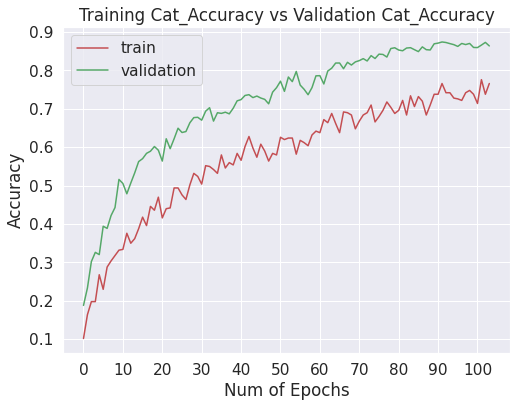

In [ ]:
# Plots for training and testing process: loss and accuracy

n_epochs = len(history.history['loss'])

plt.figure(0)
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'g')
plt.xticks(np.arange(0, n_epochs, 10.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Cat_Accuracy vs Validation Cat_Accuracy")
plt.legend(['train','validation'])




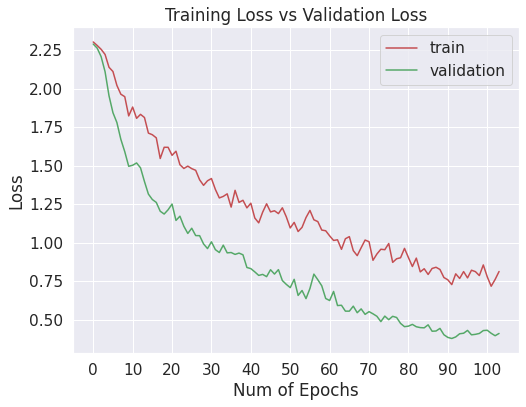

In [ ]:
plt.figure(1)
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'g')
plt.xticks(np.arange(0, n_epochs, 10.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
plt.show()


In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

RuntimeError: ignored

In [ ]:

# evaluate loaded model
scores_train = model.evaluate(x_train, y_train, verbose=0)
scores_test  = model.evaluate(x_test,  y_test,  verbose=0)

print("Accuracy Train: %.2f%% , Test: %.2f%% " % (scores_train[1]*100, scores_test[1]*100 ))

In [ ]:
# Confusion matrix result

from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict(x_test, verbose=2)

y_pred = np.argmax(Y_pred, axis=1)

y_test2 = np.argmax(y_test, axis=1)



#confusion matrix
cm = confusion_matrix(np.argmax(y_test,axis=1),y_pred)
print(cm)



In [ ]:
# Visualizing of confusion matrix
import seaborn as sn
import pandas  as pd


df_cm = pd.DataFrame(cm, range(10),range(10))
#                     range(num_classes),
#                  range(num_classes))
#plt.figure(figsize = (10,7))
plt.figure(2,figsize = (15,15) )
sn.set(font_scale=1.4) #for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12})# font size
plt.show()


In [ ]:
# use the model to predict the labels of the test data
predicted = model.predict(x_test)
expected = y_test0



# Plot the prediction
fig = plt.figure(figsize=(20, 20))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)


# plot the digits: each image is 28x28 pixels
for i in range(400):
    ax = fig.add_subplot(20, 20, i + 1, xticks=[], yticks=[])
    ax.imshow(x_test[i].reshape(img_rows, img_cols), cmap=plt.cm.binary, interpolation='nearest')

    # label the image with the target value
    if np.argmax(predicted[i]) == expected[i]:
        ax.text(0, 7, str(expected[i])+" "+str(np.argmax(predicted[i])), color='green')
    else:
        ax.text(0, 7, str(expected[i])+" "+str(np.argmax(predicted[i])), color='red')

In [ ]:
# Creates the graph.png file

! pip3 install keras-visualizer
from keras_visualizer import visualizer  

#create the graph.png image
visualizer(model=model, view=True, format='png', filename='graph')

#show the graph
import matplotlib.image as mpimg
img = mpimg.imread('graph.png')
imgplot = plt.imshow(img,)
plt.show()
